In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sys
import os
sys.path.append('/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/cascade model')
#os.chdir('/home/jif564/bancpipeline/analysis/python/')
import cascade_model
#from cascade_model import SignalCascade
#import igraph as ig
import pickle
import random
import json
import re

#### Generate seeds

In [2]:
def generate_json_from_seed_list(seed_list, seed_column, output_file):
    """
    Generates a JSON file containing dictionaries with varying 'mask_A' values from a seed list.

    Parameters:
        seed_list (list): List of strings to populate the 'mask_A' field.
        output_file (str): Path to the output JSON file.

    Returns:
        None
    """
    data = []
    for seed in seed_list:
        entry = {
            "synaptic_threshold": 0,
            "mask_A": seed,
            "mask_B": "ALLN",
            "mask_key_A": seed_column,
            "mask_key_B": "cell_class",
            "max_timesteps": 15,
            "empty_B": 1,
            "activation_threshold": 0.01,
            "n_iterations": 100
        }
        data.append(entry)
    #print (data)
    with open(output_file, 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [3]:
AN_df = pd.read_csv('/n/groups/wilson/Jingxuan/BANC-project/data/meta/AN_types.csv')
AN_df

,cell_type
0,AN_GNG_165
1,AN_GNG_11
2,AN_GNG_VES_5
3,AN_multi_127
4,AN_IPS_GNG_6
...,...
740,AN05B009
741,ANXXX008
742,AN04A001
743,AN06B004


In [ ]:
DN_df = pd.read_csv('/n/groups/wilson/Jingxuan/BANC-project/data/meta/DN_types.csv')
DN_df

#### Load data

In [3]:
def load_sqlite_database(sql_path):
    """
    Load metadata and connectivity data from SQLite database.
    
    Parameters:
    -----------
    sql_path : str
        Path to SQLite database
        
    Returns:
    --------
    tuple
        (metadata_df, edgelist_df, synapses_df)
    """
    conn = sqlite3.connect(sql_path)
    
    # List all tables (for verification)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables in the database:", tables)
    
    # Load all tables
    meta_df = pd.read_sql_query("SELECT * FROM meta", conn)
    try:
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist_simple", conn)
    except Exception as e:
        print("Failed to load 'edgelist_simple'. Error:", e)
        print("Attempting to load 'edgelist' instead.")
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist", conn)
    #synapses_df = pd.read_sql_query("SELECT * FROM synapses", conn)
    
    conn.close()
    return meta_df, edgelist_df


def construct_connectivity_matrix(edgelist):
    # Get unique nodes from 'pre' and 'post' columns
    nodes = pd.Index(edgelist['pre']).union(edgelist['post'])
    
    # Create a mapping of node labels to matrix indices
    node_to_index = {node: i for i, node in enumerate(nodes)}
    
    # Initialize an empty matrix with zeros
    connectivity_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)
    
    # Populate the matrix with 'synaptic_count' values
    for _, row in edgelist.iterrows():
        pre_index = node_to_index[row['pre']]
        post_index = node_to_index[row['post']]
        connectivity_matrix[pre_index, post_index] += row['synaptic_count']
    
    # Convert to DataFrame for easier interpretation with node labels
    connectivity_df = pd.DataFrame(connectivity_matrix, index=nodes, columns=nodes)
    return connectivity_df


In [33]:
#sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/frankenbrain_v.1.1_data.sqlite'
# O2
#sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/frankenbrain_v.1.6_data.sqlite'
#sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/banc_data.sqlite'
sql_path = '/n/data1/hms/neurobio/wilson/banc/connectivity/banc_496_data.sqlite'
# local 
#sql_path = '/Users/jingxuanfan/Documents/GitHub/sql_local/frankenbrain_v.1.5_data.sqlite'
meta_df, edgelist_df = load_sqlite_database(sql_path)

Tables in the database: [('edgelist_simple',), ('meta',)]


In [34]:
edgelist_df.head()

,pre,post,count,norm,post_count,pre_count
0,720575941644353656,720575941511186508,927,0.117223,7908,8669
1,720575941435880992,720575941492769712,878,0.305073,2878,2756
2,720575941438987071,720575941639240309,848,0.133459,6354,4005
3,720575941476954676,720575941549949812,831,0.302402,2748,2555
4,720575941521073591,720575941496268361,822,0.115791,7099,7246


banc - frankenbrain column name correspondence:
- root_id - id
- top_nt - top_nt

In [40]:
# nociception
SNxx25 = ['720575941548938356', '720575941573114619','720575941640422943','720575941432295383','720575941537649301','720575941568844276','720575941528027012','720575941586474564']
SNxx27 = ['720575941407465902']
SNxx29 = ['720575941471405664', '720575941643158354', '720575941471906602', '720575941558298660', '720575941597582784', '720575941576837969', '720575941445475348', '720575941527849638', '720575941580643449', '720575941473329450', '720575941613453532', '720575941602922681', '720575941507462750', '720575941534090418', '720575941591887656', '720575941528930232', '720575941651645937', '720575941550995967', '720575941487039440', '720575941573383581', '720575941513651532', '720575941534873432', '720575941511661521']
SAxx02 = ['720575941512261443', '720575941615285145', '720575941584961246', '720575941486460813', '720575941552842579', '720575941483052541', '720575941451040122', '720575941474229297', '720575941447163317', '720575941473812576', '720575941392665750', '720575941536037362', '720575941509737682', '720575941612517852']
SNxx20 = ['720575941568547186', '720575941561307794', '720575941503527986', '720575941558433295', '720575941556893476', '720575941588546871', '720575941517769644', '720575941566646574', '720575941449990237', '720575941680553149', '720575941437561941', '720575941501993355', '720575941522128119', '720575941515659523', '720575941531649253', '720575941404057712', '720575941507457570', '720575941573706504', '720575941642256248', '720575941492456574', '720575941652784913', '720575941564002407']
#SNch01 = []
SNxx21 = ['720575941554774756',
'720575941533572530',
'720575941487700533',
'720575941430281464',
'720575941438421459',
'720575941532582787',
'720575941639356533',
'720575941516772499',
'720575941476542260',
'720575941528057220',
'720575941662579068',
'720575941518678894',
'720575941523078647']
SNch01 = ['720575941405670703',
'720575941539841917',
'720575941405763758',
'720575941542858525',
'720575941459679888',
'720575941449699662',
'720575941631043003',
'720575941351541808',
'720575941514158083',
'720575941563142056',
'720575941597270720',
'720575941455871984',
'720575941468392823',
'720575941594410865',
'720575941565106583',
'720575941543379461',
'720575941503383100',
'720575941447893354',
'720575941732531755',
'720575941532451301',
'720575941568022522',
'720575941440646235',
'720575941603646910',
'720575941549811262',
'720575941541450525',
'720575941548965437',
'720575941505186981',
'720575941447901290',
'720575941670649767',
'720575941471497536',
'720575941430962017',
'720575941680242877',
'720575941613474323',
'720575941400789539',
'720575941473848362',
'720575941473655082',
'720575941680273341',
'720575941548457761',
'720575941558316068',
'720575941431133025',
'720575941525498212',
'720575941487028176',
'720575941504519218',
'720575941553752065',
'720575941625153132',
'720575941449210293',
'720575941574713014',
'720575941490709991',
'720575941575235176',
'720575941525966436',
'720575941589958455',
'720575941592129494',
'720575941520249523',
'720575941549129588',
'720575941585344478',
'720575941680646845',
'720575941532486885',
'720575941649347349',
'720575941452464041',
'720575941498472059',
'720575941430267055']
AN05B103 = ['720575941524165453', '720575941546022249']
AN05B098 = ['720575941644061010', '720575941413950612']
AN09B018 = ['720575941493278384', '720575941610961226']
ANXXX019 = ['720575941593607126']
CB0135 = ['720575941670129841', '720575941503645931']
AN17A009 = ['720575941561320749', '720575941519268824']
ANXXX433 = ['720575941434968974', '720575941560343155', '720575941525501517', '720575941534422360', '720575941592092968', '720575941490106830', '720575941520538803', '720575941513153745', '720575941439139535']
AN05B004 = ['720575941458813680', '720575941508517761']
CB1829 = ['720575940611496165','720575940622466027']
DNpe007 = ['720575941642462565']
IN10B004 = ['720575941535970241']
test = edgelist_df[(edgelist_df.post.isin(CB0135)) & (edgelist_df.pre.isin(DNpe007))]

- SNxx25 to AN05B098: 16
- SNxx29 to AN05B098: 39
- SAxx02 to AN05B098: 39

- SNch01 to AN09B018: 473
- SNxx20 to AN09B018: 37
- SAxx02 to AN09B018: 401
- SNxx25 to AN09B018: 60
- SNxx29 to AN09B018: 410

- SNxx25 to AN17A009: 1
- SNxx29 to AN17A009: 4
- SAxx02 to AN17A009: 2

- SAxx02 to ANXXX433: 161

In [39]:
edgelist_df[(edgelist_df.pre.isin(DNpe007))].head(10)

,pre,post,count,norm,post_count,pre_count
92205,720575941642462565,720575941730307883,31,0.035714,868,1025
110168,720575941642462565,720575941535970241,28,0.010448,2680,1025
125007,720575941642462565,720575941645086113,26,0.011102,2342,1025
143166,720575941642462565,720575941352918576,24,0.016238,1478,1025
143167,720575941642462565,720575941642462565,24,0.026966,890,1025
165192,720575941642462565,720575941546435177,22,0.019766,1113,1025
228220,720575941642462565,720575941537637091,18,0.014528,1239,1025
249385,720575941642462565,720575941438940251,17,0.031835,534,1025
273454,720575941642462565,720575941526668034,16,0.016478,971,1025
301145,720575941642462565,720575941555194369,15,0.005207,2881,1025


In [8]:

def filter_edgelist_and_update_meta(
    edgelist_df, 
    meta_df, 
    synaptic_threshold=25
):
    """
    Filter edgelist DataFrame based on synaptic count threshold.
    Update meta_df to remove neurons without any connections and append the 'top_nt' column
    from meta_df to edgelist_df based on 'pre' and 'id'.

    Parameters:
    -----------
    edgelist_df : DataFrame
        DataFrame containing the edgelist with columns ['pre', 'post', 'count', ...].
    meta_df : DataFrame
        Metadata DataFrame containing neuron information with an 'id' column and a 'top_nt' column.
    synaptic_threshold : int, optional
        Minimum total synaptic count to retain a connection. Default is 25.

    Returns:
    --------
    tuple
        (filtered_edgelist, updated_meta, filtered_out_neurons)
    """
    # Group by 'pre' and 'post' and sum synaptic counts
    grouped_edgelist = edgelist_df.groupby(['pre', 'post'], as_index=False).agg(synaptic_count=('count', 'sum'))
    filtered_pairs = grouped_edgelist[grouped_edgelist['synaptic_count'] > synaptic_threshold][['pre', 'post']]

    # Retain only rows in the original edgelist that match the filtered pairs
    filtered_edgelist = edgelist_df.merge(filtered_pairs, on=['pre', 'post'], how='inner')

    # Append 'top_nt' from meta_df to edgelist_df
    nt_mapping = meta_df.set_index('root_id')['top_nt'].to_dict()
    filtered_edgelist['top_nt'] = filtered_edgelist['pre'].map(nt_mapping)

    # Determine neurons remaining in the filtered edgelist
    remaining_neurons = set(filtered_edgelist['pre']).union(set(filtered_edgelist['post']))

    # Update the meta DataFrame to remove neurons without connections
    updated_meta = meta_df[meta_df['root_id'].isin(remaining_neurons)].copy()

    # Return the filtered edgelist, updated metadata, and the neurons that were filtered out
    filtered_out_neurons = set(meta_df['root_id']) - remaining_neurons

    return filtered_edgelist, updated_meta, filtered_out_neurons



def process_filtered_edgelist_by_nt(filtered_edgelist, is_signed, invert_nts=None):
    """
    Process the filtered edgelist by adding a new column 'effective_count',
    which adjusts the 'count' values based on specific neurotransmitters in
    the 'pre_top_nt' column if `is_signed` is True.

    Parameters:
    -----------
    filtered_edgelist : DataFrame
        The edgelist DataFrame with columns including 'pre_top_nt' and 'count'.
    invert_nts : list of str, optional
        List of neurotransmitters for which to invert the 'count' sign.
        Default is ['gaba', 'glutamate'].
    is_signed : bool, optional
        If True, invert the 'count' for specified neurotransmitters. Default is True.

    Returns:
    --------
    processed_edgelist : DataFrame
        The modified edgelist with a new column 'effective_count'.
    """
    if invert_nts is None:
        invert_nts = ['gaba', 'glutamate']  # Default neurotransmitters to invert

    # Initialize 'effective_count' as a copy of 'count'
    filtered_edgelist['effective_count'] = filtered_edgelist['count']

    if is_signed:
        # Process each neurotransmitter in the invert list
        for nt in invert_nts:
            filtered_edgelist.loc[
                filtered_edgelist.top_nt.str.contains(nt, case=False, na=False), 
                "effective_count"
            ] *= -1

    return filtered_edgelist

In [9]:
fw_elistf, fw_meta, filtered_n = filter_edgelist_and_update_meta(edgelist_df, meta_df, synaptic_threshold=0)
fw_elistf = process_filtered_edgelist_by_nt(fw_elistf, True)

In [12]:
fw_meta.cell_type.str.contains('MBON09').sum()

4

### examine pkl

In [6]:
def get_activated_cells_by_timestep(activation_probabilities, index_to_neuron, end_neurons, threshold=0.1):
    """
    Retrieve the identity of activated cells at each timestep.

    Parameters:
    -----------
    activation_probabilities : np.array
        Matrix of activation probabilities per timestep (shape: [timesteps, neurons]).
    index_to_neuron : dict
        Dictionary mapping neuron indices to their original IDs in the edgelist.
    threshold : float
        Minimum activation probability threshold to consider a neuron as "activated".

    Returns:
    --------
    activated_cells : dict
        Dictionary where keys are timesteps, and values are lists of neuron IDs
        that were activated above the threshold.
    """
    activated_cells = {}
    activated_end_neurons = {}
    end_neuron_percentages = []
    end_neuron_indices = np.array(list(end_neurons))  # Convert set to an array for indexing

    for t in range(activation_probabilities.shape[0]):  # Iterate over timesteps
        # Identify neurons with activation probabilities above the threshold
        active_nodes = np.where(activation_probabilities[t] > threshold)[0]
        
        # Map the indices back to their original neuron IDs
        active_neurons_original_ids = [index_to_neuron[node] for node in active_nodes]

        # Check which of the active neurons are in the set of end neurons
        active_end_neurons = np.intersect1d(active_neurons_original_ids, end_neuron_indices)

        # Calculate the percentage of end neurons activated
        if len(end_neurons) > 0:  # Avoid division by zero
            percentage_activated = (len(active_end_neurons) / len(end_neurons)) * 100
        else:
            percentage_activated = 0.0
        
        end_neuron_percentages.append(percentage_activated)
        
        # Store the activated neurons for this timestep
        activated_cells[t] = active_neurons_original_ids
        activated_end_neurons[t] = active_end_neurons

    return activated_cells, activated_end_neurons, end_neuron_percentages

def get_unique_types_by_step(activation_dict, meta_df):
    """
    Query the unique cell types activated at each step.

    Parameters:
    -----------
    activation_dict : dict
        Dictionary where keys are timesteps, and values are lists of activated bodyids.
    meta_df : pd.DataFrame
        Metadata DataFrame containing 'bodyid' and 'type' columns.

    Returns:
    --------
    types_by_step : dict
        Dictionary where keys are timesteps, and values are sets of unique cell types activated.
    """
    types_by_step = {}

    for step, bodyids in activation_dict.items():
        # Filter the metadata for the activated bodyids at the current step
        activated_meta = meta_df[meta_df['id'].isin(bodyids)]
        
        # Get the unique types and store them
        unique_types = set(activated_meta['cell_type'])
        types_by_step[step] = unique_types

    return types_by_step

def quantify_neurons_by_name(activation_dict, meta_df, name_substring):
    """
    Quantify the percentage of activated neurons whose names contain a given string at each timestep.

    Parameters:
    -----------
    activation_dict : dict
        Dictionary where keys are timesteps, and values are lists of activated bodyids.
    meta_df : pd.DataFrame
        Metadata DataFrame containing 'bodyid' and 'type' columns.
    name_substring : str
        Substring to search for in the 'type' column of the metadata.

    Returns:
    --------
    percentages_by_step : dict
        Dictionary where keys are timesteps, and values are percentages of activated neurons 
        whose names contain the given substring.
    """
    percentages_by_step = {}

    for step, bodyids in activation_dict.items():
        # Filter the metadata for the activated bodyids at the current step
        activated_meta = meta_df[meta_df['id'].isin(bodyids)]
        
        # Find the neurons whose 'type' contains the given substring
        matching_neurons = activated_meta[activated_meta['cell_type'].str.contains(name_substring, case=False, na=False)]
        
        # Calculate the percentage
        if len(activated_meta) > 0:  # Avoid division by zero
            percentage = (len(matching_neurons) / len(activated_meta)) * 100
        else:
            percentage = 0.0
        
        # Store the percentage for the current timestep
        percentages_by_step[step] = percentage

    return percentages_by_step


def load_results_from_pickle(file_path):
    """
    Load a result dictionary from a pickle file.

    Parameters:
    -----------
    file_path : str
        Path to the pickle file to be loaded.

    Returns:
    --------
    result_dict : dict
        Dictionary containing the loaded results.
    """
    with open(file_path, 'rb') as f:
        result_dict = pickle.load(f)
    return result_dict

def find_activated_neurons_v2(criteria_list, key_list, matrix, neuron_to_index, metadata_df):
    """
    Find time steps of activated neurons based on criteria/key pairs.

    Parameters:
        criteria_list (list of str): List of columns in `metadata_df` to filter by.
        key_list (list of str): List of keywords to filter rows in `metadata_df`.
        matrix (numpy.ndarray): 2D array (cell_id x time steps) indicating activity of cells.
        metadata_df (pd.DataFrame): DataFrame containing metadata for cells, indexed by cell_id.

    Returns:
        dict: A dictionary where keys are (criteria, key) tuples and values are lists of time step numbers, 
              repeated for each instance of activation.
    """
    if len(criteria_list) != len(key_list):
        raise ValueError("Criteria list and key list must have the same length.")

    result = {}

    for criteria, key in zip(criteria_list, key_list):
        if criteria not in metadata_df.columns:
            raise ValueError(f"Criteria '{criteria}' not found in metadata_df columns.")

       # Filter metadata for matching rows based on criteria and key
        filtered_cell_ids = metadata_df[metadata_df[criteria].str.contains(key, na=False)]['id']

        # Convert neuron IDs to indices in the matrix using neuron_to_index
        filtered_indices = [neuron_to_index[cell_id] for cell_id in filtered_cell_ids if cell_id in neuron_to_index]


        # Get all time steps where these cells are active (non-zero activity in the matrix)
        active_time_steps = []
        for idx in filtered_indices:
            active_steps = np.where(matrix[idx, :] > 0)[0]
            active_time_steps.extend(active_steps)

        # Store the result
        result[(criteria, key)] = active_time_steps

    return result


def reverse_index_to_neuron(index_to_neuron):
    """
    Create a reverse mapping from neuron to index.

    Parameters:
        index_to_neuron (dict): A dictionary mapping indices to neuron identifiers.

    Returns:
        dict: A dictionary mapping neuron identifiers to indices.
    """
    return {neuron: index for index, neuron in index_to_neuron.items()}

def plot_activated_neurons(result):
    """
    Plot a horizontal scatter plot of activated neurons with jitter.

    Parameters:
        result (dict): Dictionary where keys are (criteria, key) tuples and values are lists of time step numbers.
    """
    plt.figure(figsize=(10, 6))

    # Create the horizontal scatter plot with jitter
    for i, ((criteria, key), time_steps) in enumerate(result.items()):
        jittered_y = [i + random.uniform(-0.1, 0.1) for _ in time_steps]  # Add jitter to y-axis
        plt.scatter(time_steps, jittered_y, label=f"{criteria}: {key}", alpha=0.7)

    # Add labels and title
    plt.yticks(range(len(result)), [f"{criteria}: {key}" for criteria, key in result.keys()])
    plt.xlabel("Time Steps")
    plt.ylabel("Criteria")
    #plt.title("Horizontal Scatter Plot of Activated Neurons with Jitter")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def create_activation_distance_df(metadata_df, cell_matrix, neuron_to_index):
    """
    Creates a DataFrame with neuron IDs and the time step at which each neuron is activated.

    Parameters:
        metadata_df (pd.DataFrame): DataFrame containing metadata for cells indexed by cell_id.
        cell_matrix (np.ndarray): A 2D array (cell by time step) representing activity levels.
        neuron_to_index (dict): A dictionary mapping neuron names to row indices in cell_matrix.

    Returns:
        pd.DataFrame: A DataFrame with columns 'id' (neuron IDs) and 'distance' (time step of activation or NaN).
    """
    activation_data = []
    metadata_df['id'] = metadata_df['id'].astype('string')

    for neuron_id in metadata_df['id']:
        #print(type(neuron_id))
        index = neuron_to_index.get(neuron_id, None)
        if index is not None:
            # Find the first time step where the neuron is activated
            activation_steps = np.where(cell_matrix[index, :] > 0)[0]
            distance = activation_steps[0] if activation_steps.size > 0 else np.nan
        else:
            distance = np.nan

        activation_data.append({'id': neuron_id, 'distance': distance})
    result_df = pd.DataFrame(activation_data)
    result_df['id'] = result_df['id'].fillna('NaN').astype('string')
    result_df['id'] = result_df['id'].fillna('missing').astype('string')
    return result_df.sort_values(by='distance', na_position='last')


def list_all_paths(input_dir):
    """
    Recursively list all paths (files and directories) under the given input directory.
    
    Args:
        input_dir (str): The input directory path.
        
    Returns:
        list: A list of all file and directory paths under the input directory.
    """
    all_paths = []
    for root, dirs, files in os.walk(input_dir):
        # Add directories to the list
        for dir_name in dirs:
            all_paths.append(os.path.join(root, dir_name))
        # Add files to the list
        for file_name in files:
            all_paths.append(os.path.join(root, file_name))
    return all_paths


def load_results_from_directory(input_dir, save_path):
    """
    Load all results from a directory of pickle files and save distance DataFrames as .pkl files.
    
    Args:
        input_dir (str): The input directory path.
        save_path (str): The directory to save the resulting .pkl files.
        
    Returns:
        dict: A dictionary where keys are file names and values are loaded results.
    """
    # Ensure save_path exists
    os.makedirs(save_path, exist_ok=True)
    
    all_files = list_all_paths(input_dir)
    results = {}
    for file_path in all_files:
        if file_path.endswith('.pkl'):  # Only process .pkl files
            # Load results from pickle file
            result_dict = load_results_from_pickle(file_path)
            activation_probabilities = result_dict['probabilities']
            neuron_to_index = reverse_index_to_neuron(result_dict['index_to_neuron'])
            
            # Create the distance DataFrame
            distance_df = create_activation_distance_df(meta_df, activation_probabilities.T, neuron_to_index)
            
            # Save the DataFrame as a .pkl file
            pkl_file_name = os.path.basename(file_path)  # Get the .pkl file name
            #print(pkl_file_name)
            cleaned_name = re.sub(r'[^a-zA-Z0-9_]', '', os.path.splitext(pkl_file_name)[0])
            result_pkl_name = cleaned_name + '_distance.pkl'  # Append _distance to name
            result_pkl_path = os.path.join(save_path, result_pkl_name)
            distance_df.to_pickle(result_pkl_path)  # Save DataFrame as .pkl
            


In [7]:
save_path = '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.5/an2'
input_dir = '/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/cascade model/cascade_results/an2/signed'
load_results_from_directory(input_dir, save_path)

In [10]:
result_dict = load_results_from_pickle('/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/cascade model/cascade_results/modality/frankenbrain_v.1.5/signed/olfactory_to_all_signed.pkl')
criteria_list = ['cell_class', 'cell_class','cell_class', 'cell_type', 'cell_type', 'cell_type', 'cell_type', 'cell_type', 'cell_type', 'cell_type', 'cell_type','cell_class','cell_class','cell_class']
key_list = ['ALLN', 'ALPN', 'LHLN','KCg','KCab','KCapbp','KCab-p','KCg-d','PPL','PAM','MBON','LHCENT','CX', 'descending']
activation_probabilities = result_dict['probabilities']
neuron_to_index = reverse_index_to_neuron(result_dict['index_to_neuron'])

In [11]:
result_list = find_activated_neurons_v2(criteria_list[::-1], key_list[::-1], activation_probabilities.T, neuron_to_index,meta_df)

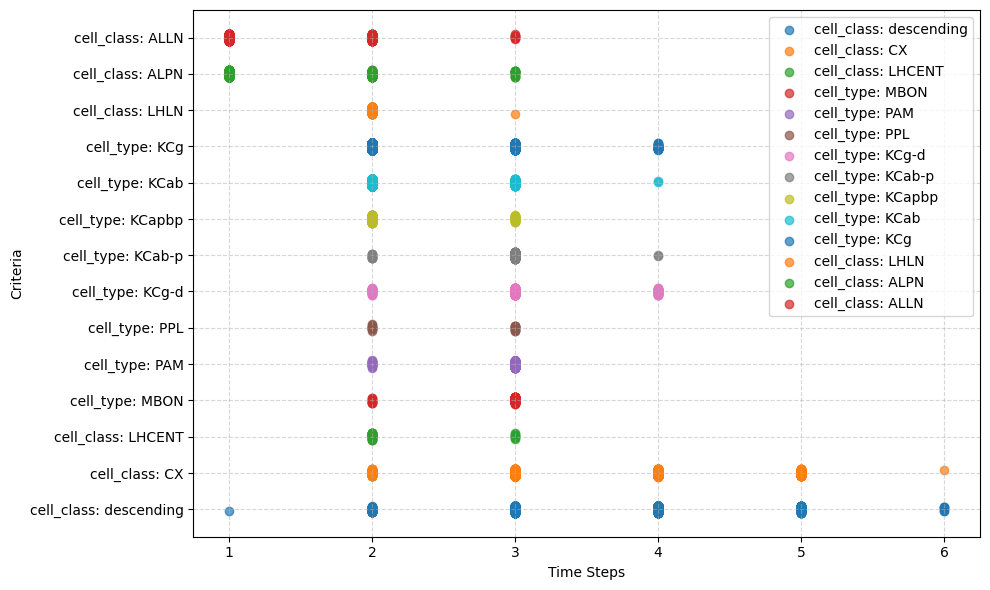

In [12]:
plot_activated_neurons(result_list)

### JF MBON cascade

In [75]:
def get_activated_cells_by_timestep(activation_probabilities, index_to_neuron, meta_df, cell_class, threshold=0.1):
    """
    Retrieve the cell_type of activated neurons belonging to a given cell_class at each timestep.

    Parameters:
    -----------
    activation_probabilities : np.array
        Matrix of activation probabilities per timestep (shape: [timesteps, neurons]).
    index_to_neuron : dict
        Dictionary mapping neuron indices to their original IDs in the edgelist.
    meta_df : pd.DataFrame
        Metadata DataFrame containing `id`, `cell_type`, and `cell_class` columns.
    cell_class : str
        The cell class to filter neurons.
    threshold : float
        Minimum activation probability threshold to consider a neuron as "activated".

    Returns:
    --------
    activated_cells : dict
        Dictionary where keys are timesteps, and values are lists of neuron IDs that were activated above the threshold.
    cell_types_by_timestep : dict
        Dictionary where keys are timesteps, and values are lists of `cell_type` of activated neurons belonging to the given `cell_class`.
    """
    activated_cells = {}
    cell_types_by_timestep = {}

    # Create a lookup table from the metadata DataFrame
    neuron_to_cell_type = meta_df.set_index('id')['cell_type'].to_dict()
    neuron_to_cell_class = meta_df.set_index('id')['cell_class'].to_dict()

    for t in range(activation_probabilities.shape[0]):  # Iterate over timesteps
        # Identify neurons with activation probabilities above the threshold
        active_nodes = np.where(activation_probabilities[t] > threshold)[0]

        # Map the indices back to their original neuron IDs
        active_neurons_original_ids = [index_to_neuron[node] for node in active_nodes]

        # Filter neurons by cell_class
        active_neurons_in_class = [neuron for neuron in active_neurons_original_ids
                                   if neuron_to_cell_class.get(neuron) == cell_class]

        # Retrieve their cell types
        active_cell_types = [neuron_to_cell_type.get(neuron) for neuron in active_neurons_in_class]

        # Store the results for this timestep
        activated_cells[t] = active_neurons_original_ids
        cell_types_by_timestep[t] = active_cell_types

    return activated_cells, cell_types_by_timestep


In [93]:
result_dict = load_results_from_pickle('/Users/jingxuanfan/Documents/GitHub/BANC-project/python/MB_analysis/cascade model/cascade_results/frankenbrain_v.1.1/signed/MBON09_to_all_signed.pkl')
criteria_list = ['cell_type', 'cell_type','cell_type','cell_type','cell_type', 'cell_type','cell_type','cell_type','cell_type', 'cell_type', 'cell_type','cell_type','cell_type', 'cell_type', 'cell_class','cell_class']
key_list = ['PPL','PAM','PAM12','PAM07','PAM08','hDelta', 'hDeltaB','hDeltaA','vDelta', 'FB4','4D3','CB.FB3','FB5','CB.FB5D4','CX', 'descending']
activation_probabilities = result_dict['probabilities']
neuron_to_index = reverse_index_to_neuron(result_dict['index_to_neuron'])

In [94]:
activated_cells, cell_types_by_timestep = get_activated_cells_by_timestep(activation_probabilities, result_dict['index_to_neuron'], fw_meta, 'CX', threshold=0.1)

In [95]:
result_list = find_activated_neurons_v2(criteria_list[::-1], key_list[::-1], activation_probabilities.T, neuron_to_index,meta_df)

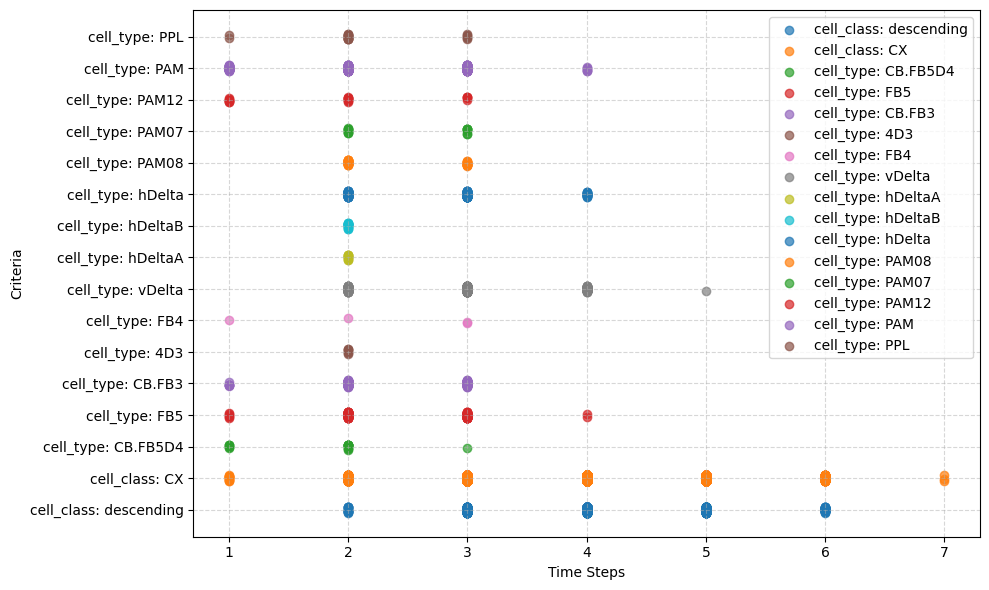

In [96]:
plot_activated_neurons(result_list)

### CSV analysis

In [15]:
# Path to your pickle file
pickle_file_path = '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.5/signed/olfactory_to_all_signed_distance.pkl'

# Open the file in read-binary mode and load the data
with open(pickle_file_path, 'rb') as file:
    df = pickle.load(file)

In [29]:
def plot_distance_histograms(df1, df2, id_column='id', distance_column='distance', super_class_column='super_class'):
    """
    Merge two DataFrames on a common ID column and plot overlayed histograms
    of a numeric column (distance) grouped by a categorical column (super_class).
    
    Parameters:
        df1 (pd.DataFrame): First DataFrame containing ID and distance columns.
        df2 (pd.DataFrame): Second DataFrame containing ID and super_class columns.
        id_column (str): Column name used as the common ID to merge the DataFrames.
        distance_column (str): Column name for the numeric column (distance) in df1.
        super_class_column (str): Column name for the categorical column in df2.
        
    Returns:
        None: Displays the histogram plot.
    """
    # Merge the DataFrames on the ID column
    merged_df = pd.merge(df1, df2, on=id_column)
    # Get unique classes for coloring
    unique_classes = merged_df[super_class_column].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Group by super_class and plot histograms
    for super_class, color in zip(unique_classes, colors):
        group = merged_df[merged_df[super_class_column] == super_class]
        plt.hist(group[distance_column], bins=10, alpha=0.5, label=f'{super_class_column} {super_class}', color=color)
    
    # Add plot details
    plt.title(f'Overlayed Histograms of {distance_column.capitalize()} by {super_class_column.capitalize()}')
    plt.xlabel(distance_column.capitalize())
    plt.ylabel('Frequency')
    # Place the legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    
    plt.grid(True)
    plt.show()


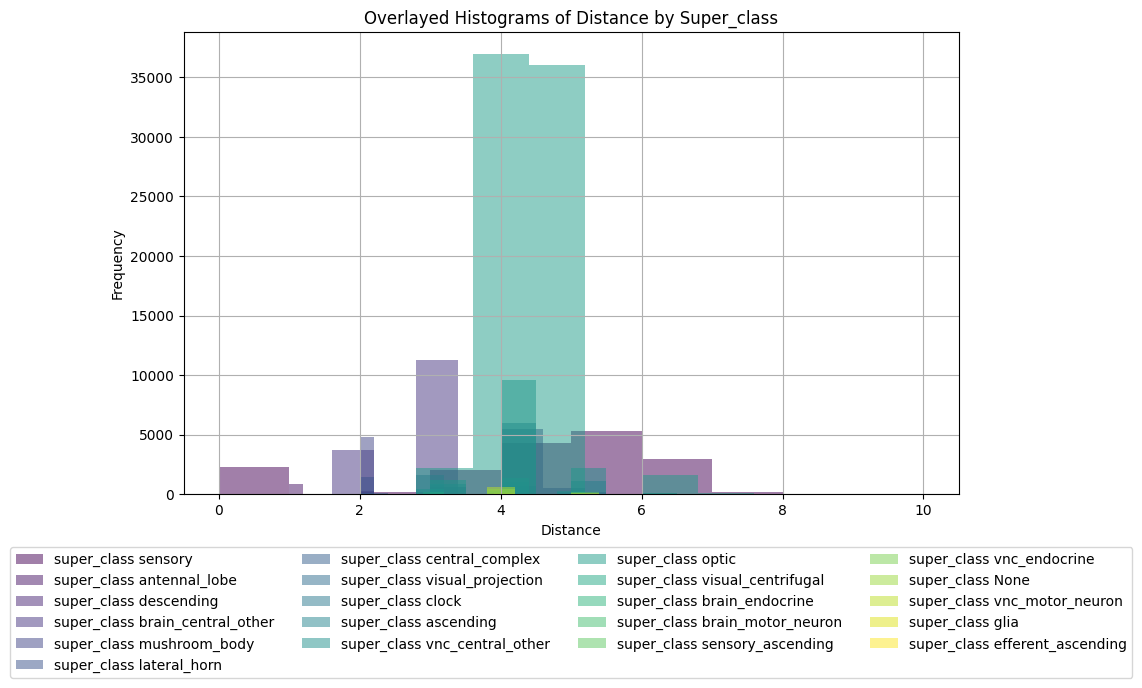

In [30]:
plot_distance_histograms(df, meta_df)

### MB analysis

In [53]:
cell_type_by_time = get_unique_types_by_step(activated_cells, fw_meta)

In [103]:
def get_pre_neuron_cell_types(activated_cells, meta_df, edgelist, target_cell_type):
    """
    Find the cell type names of pre-neurons activated in the previous time step
    for neurons of a specific target cell type.
    
    Parameters:
        activated_cells (dict): Dictionary with time steps as keys and lists of activated neuron IDs as values.
        meta_df (pd.DataFrame): DataFrame with columns 'id' and 'cell_type'.
        edgelist (pd.DataFrame): DataFrame with columns 'pre' and 'post', representing connections.
        target_cell_type (str): Target cell type (e.g., 'CB.FB5D4').
    
    Returns:
        dict: A dictionary where keys are time steps and values are lists of cell type names for pre-neurons.
    """
    # Step 1: Filter IDs of neurons with the target cell type
    target_ids = meta_df.loc[meta_df['cell_type'].str.contains(target_cell_type), 'id'].tolist()

    # Step 2: Identify pre-neurons linked to these IDs in the edgelist
    pre_neurons = edgelist.loc[edgelist['post'].isin(target_ids), 'pre'].unique().tolist()

    # Step 3: Find time steps in activated_cells where target cell type neurons are activated
    activated_target_steps = [
        time_step for time_step, neurons in activated_cells.items()
        if any(neuron in target_ids for neuron in neurons)
    ]

    # Step 4: Check previous time steps for activated pre-neurons
    result = {}
    for time_step in activated_target_steps:
        previous_step = time_step - 1
        if previous_step >= 0 and previous_step in activated_cells:
            # Find activated pre-neurons in the previous time step
            activated_pre_neurons = [
                neuron for neuron in activated_cells[previous_step] if neuron in pre_neurons
            ]
            
            # Map neuron IDs to their cell type names
            pre_neuron_cell_types = meta_df.loc[meta_df['id'].isin(activated_pre_neurons), 'cell_type'].tolist()
            result[time_step] = pre_neuron_cell_types

    return result


In [104]:
result = get_pre_neuron_cell_types(
    activated_cells=activated_cells, 
    meta_df=fw_meta, 
    edgelist=fw_elistf, 
    target_cell_type='CB.FB5D4'
)

print(result)


{1: ['MBON09', 'MBON09', 'MBON09', 'MBON09'], 2: ['CB.FB3,4D0', 'CB.FB3,4D1', 'CB.FB3,4I3', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB5D4', 'CB1151', 'CB2736', 'CB2736', 'CRE048', 'CRE056', 'CRE065', 'CREl1_30', 'EBa1_14', 'LAL154', 'LAL154', 'LAL185', 'LAL185', 'LHPV7c1', 'MBON21', 'MBON21', 'MBON30', 'MBON30', 'PLP162', 'PLP162', 'PPL108', 'SMP075b', 'SMP254', 'SMP254', 'CB.FB3,4D1', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB5D4', 'CRE065', 'CRE060,CRE067', 'CRE060,CRE067', 'CRE065', 'CREl1_30', 'LAL185', 'SMP152', '', 'CRE068', 'CB0933', 'CB1287', 'CRE021', 'CB0114', 'LHPV7c1', 'SMP163', 'CB1287', 'CB1970', 'CRE065', 'MBON25,MBON34', 'CB0114', 'CB2025', 'CRE009', 'CRE100', 'EBa1_14', 'LAL002', 'LAL129', 'LAL129', 'LAL185', 'LHCENT3', 'PLP162', 'PPL108', 'SMP152', 'SMP163', 'SMP586'], 3: ['AOTU020', 'ATL026', 'ATL027', 'ATL029', 'ATL037', 'AVLP563', 'CB.FB2E1', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,4A2', 'CB.FB3,

In [105]:
result = get_pre_neuron_cell_types(
    activated_cells=activated_cells, 
    meta_df=fw_meta, 
    edgelist=fw_elistf, 
    target_cell_type='CB.FB3'
)

print(result)


{1: ['MBON09', 'MBON09', 'MBON09', 'MBON09'], 2: ['ALIN1', 'AVLP494', 'CB.FB3,4D0', 'CB.FB3,4D1', 'CB.FB3,4D1', 'CB.FB3,4I3', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB5D4', 'CB0933', 'CB1061', 'CB1079', 'CB1079', 'CB1079', 'CB1079', 'CB1079', 'CB1151', 'CB1151', 'CB1171', 'CB1357', 'CB1454', 'CB1454', 'CB1454', 'CB1857', 'CB1857', 'CB2018', 'CB2018', 'CB2025', 'CB2357', 'CB2357', 'CB2357', 'CB2357', 'CB2564', 'CB2736', 'CB2736', 'CB2736', 'CB2860', 'CB3077', 'CB3458', 'CB3458', 'CB3458', 'CB3778', 'CRE048', 'CRE050', 'CRE056', 'CRE056', 'CRE056', 'CRE056', 'CRE065', 'CRE080a', 'CRE103b', 'CREl1_30', 'EBa1_14', 'EBa1_14', 'KCapbp-ap2', 'KCapbp-ap2', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCapbp-m', 'KCg-d', 'KCg-d', 'KCg-m', 'LAL043a', 'LAL154', 'LAL154', 'LAL185', 'LAL185', 'LAL198', 'LHAV9a1_a', 'LHPD5d1', 'LHPV10b1', 'LHPV4m1', 'LHPV7c1', 'MBON10', 'MBON21', 'MBON21', 'MBON22', 'MBON30', 'MBON30', 'PLP162', 'PLP162', 'PPL108', 'SLP242', 'SMP075a', '

In [106]:
result = get_pre_neuron_cell_types(
    activated_cells=activated_cells, 
    meta_df=fw_meta, 
    edgelist=fw_elistf, 
    target_cell_type='hDeltaB'
)

print(result)


{2: ['CB.FB3,4D0', 'CB.FB3,4D1', 'CB.FB3,4D1', 'CB.FB3,4I3', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB3,4D1', 'CB.FB3,4D1', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB3,4A3']}


In [107]:
result = get_pre_neuron_cell_types(
    activated_cells=activated_cells, 
    meta_df=fw_meta, 
    edgelist=fw_elistf, 
    target_cell_type='hDeltaA'
)

print(result)


{2: ['CB.FB3,4D0', 'CB.FB3,4I3', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB3,4D1', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB5D4', 'CB.FB3,4A3']}


### old analysis

In [47]:
activation_probabilities = result_dict['probabilities']
index_to_neuron = result_dict['index_to_neuron']
end_neurons = np.array(fw_meta[fw_meta["cell_type"].str.contains("PAM", case=False, na=False)]["id"])
activated_cells, activated_end_cells, end_neuron_percentages = get_activated_cells_by_timestep(activation_probabilities, index_to_neuron, end_neurons)

In [48]:
types_by_step = get_unique_types_by_step(activated_end_cells, fw_meta)
print(f'step 1: {types_by_step[1]} and FB4R present? {any("FB4R" in s for s in types_by_step[1])}')
print(f'step 2: {types_by_step[2]} and FB4R present? {any("FB4R" in s for s in types_by_step[2])}')
print(f'step 3: {types_by_step[3]} and FB4R present? {any("FB4R" in s for s in types_by_step[3])}')
print(f'step 4: {types_by_step[4]} and FB4R present? {any("FB4R" in s for s in types_by_step[4])}')
print(f'step 5: {types_by_step[5]} and FB4R present? {any("FB4R" in s for s in types_by_step[5])}')

step 1: set() and FB4R present? False
step 2: set() and FB4R present? False
step 3: set() and FB4R present? False
step 4: {'PAM08', 'PAM04', 'PAM06'} and FB4R present? False
step 5: {'PAM10', 'PAM05', 'PAM07'} and FB4R present? False


In [49]:
types_by_step

{0: set(),
 1: set(),
 2: set(),
 3: set(),
 4: {'PAM04', 'PAM06', 'PAM08'},
 5: {'PAM05', 'PAM07', 'PAM10'},
 6: {'PAM08', 'PAM09'},
 7: set(),
 8: set(),
 9: set(),
 10: set()}

In [40]:
print(f'step 1: FB5V present? {any("FB5V" in s for s in types_by_step[1])}')
print(f'step 2: FB5V present? {any("FB5V" in s for s in types_by_step[2])}')
print(f'step 3: FB5V present? {any("FB5V" in s for s in types_by_step[3])}')
print(f'step 4: FB5V present? {any("FB5V" in s for s in types_by_step[4])}')
print(f'step 5: FB5V present? {any("FB5V" in s for s in types_by_step[5])}')


step 1: FB5V present? False
step 2: FB5V present? False
step 3: FB5V present? False
step 4: FB5V present? False
step 5: FB5V present? False


In [48]:
print(f'step 1: hDelta present? {any("hDelta" in s for s in types_by_step[1])}')
print(f'step 2: hDelta present? {any("hDelta" in s for s in types_by_step[2])}')
print(f'step 3: hDelta present? {any("hDelta" in s for s in types_by_step[3])}')
print(f'step 4: hDelta present? {any("hDelta" in s for s in types_by_step[4])}')
print(f'step 5: hDelta present? {any("hDelta" in s for s in types_by_step[5])}')


step 1: hDelta present? False
step 2: hDelta present? False
step 3: hDelta present? False
step 4: hDelta present? True
step 5: hDelta present? True


In [49]:
print(f'step 1: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[1])}')
print(f'step 2: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[2])}')
print(f'step 3: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[3])}')
print(f'step 4: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[4])}')
print(f'step 5: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[5])}')


step 1: hDeltaB present? False
step 2: hDeltaB present? False
step 3: hDeltaB present? False
step 4: hDeltaB present? True
step 5: hDeltaB present? True


In [51]:
print(f'step 1: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[1])}')
print(f'step 2: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[2])}')
print(f'step 3: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[3])}')
print(f'step 4: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[4])}')
print(f'step 5: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[5])}')


step 1: hDeltaA present? False
step 2: hDeltaA present? False
step 3: hDeltaA present? False
step 4: hDeltaA present? False
step 5: hDeltaA present? True


In [45]:
end_neuron_percentages

[0.0,
 0.6172839506172839,
 2.57201646090535,
 9.670781893004115,
 13.991769547325102,
 8.333333333333332]

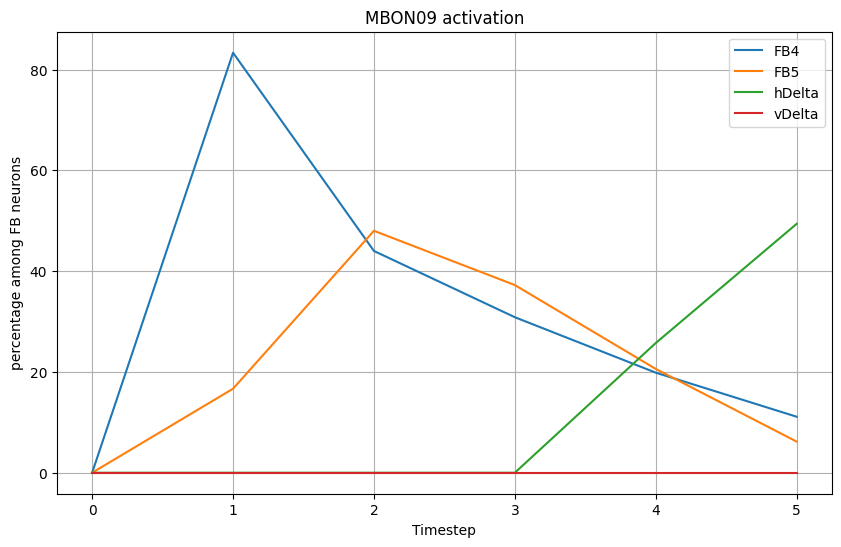

In [56]:
def plot_activation_trends_using_quantify(activation_dict, meta_df, type_list):
    """
    Calculate and visualize activation trends for multiple types using the quantify_neurons_by_name function.

    Parameters:
    -----------
    activation_dict : dict
        Dictionary where keys are timesteps, and values are lists of activated bodyids.
    meta_df : pd.DataFrame
        Metadata DataFrame containing 'bodyid' and 'type' columns.
    type_list : list
        List of strings representing neuron types or substrings to analyze.

    Returns:
    --------
    trends : dict
        Dictionary where keys are types from `type_list`, and values are lists of 
        percentages of activation per timestep.
    """
    trends = {}

    for neuron_type in type_list:
        # Use quantify_neurons_by_name to calculate trends for this neuron type
        trends[neuron_type] = list(quantify_neurons_by_name(activation_dict, meta_df, neuron_type).values())

    # Visualization
    plt.figure(figsize=(10, 6))
    for neuron_type, percentages in trends.items():
        plt.plot(list(activation_dict.keys()), percentages, label=neuron_type)

    plt.xlabel("Timestep")
    plt.ylabel("percentage among FB neurons")
    plt.title("MBON09 activation")
    plt.legend()
    plt.grid(True)
    plt.show()

    return trends

type_list = ['FB4', 'FB5', 'hDelta', 'vDelta']
trends = plot_activation_trends_using_quantify(activated_end_cells, fw_meta, type_list)


In [57]:
result_dict = load_results_from_pickle('cascade_results/cascade_results_MBON21_to_FB_hdelta_vdelta.pkl')

In [58]:
activation_probabilities = result_dict['probabilities']
index_to_neuron = result_dict['index_to_neuron']
end_neurons = np.array(fw_meta[fw_meta["type"].str.contains(r"FB|hdelta|vdelta", case=False, na=False)]["bodyid"])
activated_cells, activated_end_cells, end_neuron_percentages = get_activated_cells_by_timestep(activation_probabilities, index_to_neuron, end_neurons)

In [59]:
types_by_step = get_unique_types_by_step(activated_end_cells, fw_meta)
print(f'step 1: {types_by_step[1]} and FB4R present? {any("FB4R" in s for s in types_by_step[1])}')
print(f'step 2: {types_by_step[2]} and FB4R present? {any("FB4R" in s for s in types_by_step[2])}')
print(f'step 3: {types_by_step[3]} and FB4R present? {any("FB4R" in s for s in types_by_step[3])}')
print(f'step 4: {types_by_step[4]} and FB4R present? {any("FB4R" in s for s in types_by_step[4])}')
print(f'step 5: {types_by_step[5]} and FB4R present? {any("FB4R" in s for s in types_by_step[5])}')

step 1: {'FB4C', 'FB4R', 'FB4P_b'} and FB4R present? True
step 2: {'FB5Y', 'FB5X', 'FB4M', 'FB4I', 'FB4G', 'FB5F', 'FB4A', 'FB1H', 'FB4Y', 'FB5Q'} and FB4R present? False
step 3: {'FB4O', 'FB6M', 'FB2L', 'FB5Y', 'FB2B_a', 'FB5AB', 'FB5D', 'FB6A', 'hDeltaK', 'FB4M', 'FB6T', 'FB6H', 'FB5A', 'FB5L', 'FB4D', 'FB4F_b', 'FB7E', 'FB5K', 'FB4J', 'FB4H', 'FB5X', 'FB6D', 'FB8I', 'FB5P', 'FB5N', 'FB8F_b', 'FB7L', 'FB8F_a', 'FB6E', 'FB2G_a', 'FB4X', 'FB3A', 'FB5G', 'FB5H', 'FB4P_b', 'FB5F', 'FB5Z', 'FB5T', 'FB6N', 'FB6V', 'FB4Q_b', 'FB4F_a', 'FB5B', 'FB4N', 'FB4I', 'FB5I', 'FB4G', 'FB6U', 'FB1G', 'FB4P_a', 'FB4Q_a', 'FB4K', 'FB6X', 'FB2M', 'FB5V', 'FB5Q'} and FB4R present? False
step 4: {'FB6F', 'FB4O', 'FB2A', 'FB6M', 'FB5C', 'FB2L', 'FB2G_b', 'FB5Y', 'FB5D', 'FB6A', 'hDeltaK', 'FB6H', 'FB5O', 'FB5AA', 'FB2K', 'FB4D', 'FB4F_b', 'FB7E', 'FB1F', 'FB7I', 'FB5X', 'FB6D', 'FB2I_b', 'FB6B', 'FB5P', 'hDeltaB', 'FB8C', 'FB4B', 'FB5N', 'FB4Y', 'FB4C', 'FB3A', 'FB5G', 'FB5E', 'FB3D', 'FB4L', 'hDeltaH', 'FB

In [60]:
print(f'step 1: FB5V present? {any("FB5V" in s for s in types_by_step[1])}')
print(f'step 2: FB5V present? {any("FB5V" in s for s in types_by_step[2])}')
print(f'step 3: FB5V present? {any("FB5V" in s for s in types_by_step[3])}')
print(f'step 4: FB5V present? {any("FB5V" in s for s in types_by_step[4])}')
print(f'step 5: FB5V present? {any("FB5V" in s for s in types_by_step[5])}')


step 1: FB5V present? False
step 2: FB5V present? False
step 3: FB5V present? True
step 4: FB5V present? True
step 5: FB5V present? False


In [61]:
print(f'step 1: hDelta present? {any("hDelta" in s for s in types_by_step[1])}')
print(f'step 2: hDelta present? {any("hDelta" in s for s in types_by_step[2])}')
print(f'step 3: hDelta present? {any("hDelta" in s for s in types_by_step[3])}')
print(f'step 4: hDelta present? {any("hDelta" in s for s in types_by_step[4])}')
print(f'step 5: hDelta present? {any("hDelta" in s for s in types_by_step[5])}')


step 1: hDelta present? False
step 2: hDelta present? False
step 3: hDelta present? True
step 4: hDelta present? True
step 5: hDelta present? True


In [62]:
print(f'step 1: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[1])}')
print(f'step 2: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[2])}')
print(f'step 3: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[3])}')
print(f'step 4: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[4])}')
print(f'step 5: hDeltaB present? {any("hDeltaB" in s for s in types_by_step[5])}')


step 1: hDeltaB present? False
step 2: hDeltaB present? False
step 3: hDeltaB present? False
step 4: hDeltaB present? True
step 5: hDeltaB present? True


In [63]:
print(f'step 1: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[1])}')
print(f'step 2: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[2])}')
print(f'step 3: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[3])}')
print(f'step 4: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[4])}')
print(f'step 5: hDeltaA present? {any("hDeltaA" in s for s in types_by_step[5])}')


step 1: hDeltaA present? False
step 2: hDeltaA present? False
step 3: hDeltaA present? False
step 4: hDeltaA present? False
step 5: hDeltaA present? True


In [24]:
result_dict = load_results_from_pickle('cascade_results/cascade_results_664978073_818796911_850182049_1132150724_to_rMBON_PAM_PPL.pkl')
activation_probabilities = result_dict['probabilities']
index_to_neuron = result_dict['index_to_neuron']
end_neurons = np.array(fw_meta[fw_meta["type"].str.contains(r"MBON|PAM|PPL", case=False, na=False)]["bodyid"])
activated_cells, activated_end_cells, end_neuron_percentages = get_activated_cells_by_timestep(activation_probabilities, index_to_neuron, end_neurons)

In [25]:
types_by_step = get_unique_types_by_step(activated_end_cells, fw_meta)
print(f'step 1: {types_by_step[1]} and PAM12 present? {any("PAM12" in s for s in types_by_step[1])}')
print(f'step 2: {types_by_step[2]} and PAM12 present? {any("PAM12" in s for s in types_by_step[2])}')
print(f'step 3: {types_by_step[3]} and PAM12 present? {any("PAM12" in s for s in types_by_step[3])}')
print(f'step 4: {types_by_step[4]} and PAM12 present? {any("PAM12" in s for s in types_by_step[4])}')
print(f'step 5: {types_by_step[5]} and PAM12 present? {any("PAM12" in s for s in types_by_step[5])}')

step 1: set() and PAM12 present? False
step 2: {'MBON30', 'MBON35'} and PAM12 present? False
step 3: {'MBON16', 'MBON04', 'MBON31', 'MBON17', 'MBON29', 'MBON26', 'MBON06', 'MBON24', 'PAM08_b', 'PPL107', 'MBON20', 'MBON27'} and PAM12 present? False
step 4: {'PAM06_a', 'MBON33', 'MBON15', 'MBON21', 'MBON35', 'PPL107', 'MBON13', 'MBON19', 'PPL101', 'PPL108', 'PPL102', 'PAM10', 'MBON14', 'MBON17-like', 'PPL203', 'PPL104', 'PAM08_d', 'MBON03', 'PAM05', 'PPL201', 'PPL106', 'PPL105', 'MBON31', 'MBON12', 'MBON32', 'MBON15-like', 'MBON10', 'MBON18', 'MBON23', 'PAM08_c', 'MBON28', 'MBON05', 'MBON22', 'PAM11', 'PPL204', 'MBON02', 'PPL103', 'MBON09', 'MBON16', 'MBON11', 'PPL202', 'MBON01', 'PAM08_b', 'PAM14', 'MBON07'} and PAM12 present? False
step 5: {'PAM06_a', 'MBON15', 'MBON21', 'PAM15_a', 'PPL108', 'MBON25', 'PAM15_b', 'PAM10', 'MBON17-like', 'PPL203', 'PAM02', 'PPL104', 'PAM08_a', 'PAM13', 'PAM12', 'PAM01_a', 'PPL106', 'PAM04_b', 'MBON31', 'MBON15-like', 'PAM06_b', 'MBON10', 'PAM08_c', 'MBON

In [26]:
print(f'step 1: PAM08 present? {any("PAM08" in s for s in types_by_step[1])}')
print(f'step 2: PAM08 present? {any("PAM08" in s for s in types_by_step[2])}')
print(f'step 3: PAM08 present? {any("PAM08" in s for s in types_by_step[3])}')
print(f'step 4: PAM08 present? {any("PAM08" in s for s in types_by_step[4])}')
print(f'step 5: PAM08 present? {any("PAM08" in s for s in types_by_step[5])}')


step 1: PAM08 present? False
step 2: PAM08 present? False
step 3: PAM08 present? True
step 4: PAM08 present? True
step 5: PAM08 present? True


In [27]:
print(f'step 1: PAM07 present? {any("PAM07" in s for s in types_by_step[1])}')
print(f'step 2: PAM07 present? {any("PAM07" in s for s in types_by_step[2])}')
print(f'step 3: PAM07 present? {any("PAM07" in s for s in types_by_step[3])}')
print(f'step 4: PAM07 present? {any("PAM07" in s for s in types_by_step[4])}')
print(f'step 5: PAM07 present? {any("PAM07" in s for s in types_by_step[5])}')


step 1: PAM07 present? False
step 2: PAM07 present? False
step 3: PAM07 present? False
step 4: PAM07 present? False
step 5: PAM07 present? True


In [28]:
print(f'step 1: MBON21 present? {any("MBON21" in s for s in types_by_step[1])}')
print(f'step 2: MBON21 present? {any("MBON21" in s for s in types_by_step[2])}')
print(f'step 3: MBON21 present? {any("MBON21" in s for s in types_by_step[3])}')
print(f'step 4: MBON21 present? {any("MBON21" in s for s in types_by_step[4])}')
print(f'step 5: MBON21 present? {any("MBON21" in s for s in types_by_step[5])}')


step 1: MBON21 present? False
step 2: MBON21 present? False
step 3: MBON21 present? False
step 4: MBON21 present? True
step 5: MBON21 present? True


In [29]:
print(f'step 1: MBON09 present? {any("MBON09" in s for s in types_by_step[1])}')
print(f'step 2: MBON09 present? {any("MBON09" in s for s in types_by_step[2])}')
print(f'step 3: MBON09 present? {any("MBON09" in s for s in types_by_step[3])}')
print(f'step 4: MBON09 present? {any("MBON09" in s for s in types_by_step[4])}')
print(f'step 5: MBON09 present? {any("MBON09" in s for s in types_by_step[5])}')


step 1: MBON09 present? False
step 2: MBON09 present? False
step 3: MBON09 present? False
step 4: MBON09 present? True
step 5: MBON09 present? True


### Examine Rachel's seeds

In [4]:
criteria_df = pd.read_csv('/n/groups/wilson/Jingxuan/BANC-project/data/meta/franken_meta_20250314.csv',low_memory=False)
#criteria_df['neuron_id'] = criteria_df['neuron_id'].astype('int64')
criteria_df['neuron_id'] = criteria_df['neuron_id'].replace([np.inf, -np.inf], np.nan).fillna(-1).astype('int64')


In [5]:
criteria_df

,neuron_id,flow,super_class,cell_class,cell_sub_class,body_part_sensory,cell_type,seed_01,seed_03,seed_09,seed_10
0,720575940630915712,brain_afferent,sensory,['olfactory'],NaN,antenna,ORN_DM6,olfactory,antenna_olfactory,NaN,antennal_lobe_sensory
1,720575940620993664,brain_afferent,sensory,['olfactory'],['pheromone'],antenna,ORN_VA1v,olfactory,antenna_olfactory,NaN,antennal_lobe_sensory
2,720575940603453312,brain_intrinsic,antennal_lobe,['ALPN'],['multiglomerular'],NaN,"(M_adPNm4,M_adPNm5)a",NaN,NaN,NaN,NaN
3,720575940630003456,brain_intrinsic,antennal_lobe,['ALPN'],['multiglomerular'],NaN,"(M_adPNm4,M_adPNm5)b",NaN,NaN,NaN,NaN
4,720575940614316672,brain_intrinsic,antennal_lobe,['ALPN'],['multiglomerular'],NaN,"(M_adPNm4,M_adPNm5)b",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
188670,720575940631021056,brain_intrinsic,optic,"['M', 'E']","['t', 'a', 'n', 'g', 'e', 'n', 't', 'i', 'a', ...",NaN,CB3832,NaN,NaN,NaN,NaN
188671,720575940631019264,brain_intrinsic,optic,"['M', 'E']","['t', 'a', 'n', 'g', 'e', 'n', 't', 'i', 'a', ...",NaN,CB3832,NaN,NaN,NaN,NaN
188672,720575940624488448,brain_intrinsic,optic,"['M', 'E']","['t', 'a', 'n', 'g', 'e', 'n', 't', 'i', 'a', ...",NaN,CB3832,NaN,NaN,NaN,NaN
188673,720575940633117696,brain_intrinsic,optic,"['M', 'E']","['t', 'a', 'n', 'g', 'e', 'n', 't', 'i', 'a', ...",NaN,CB3832,NaN,NaN,NaN,NaN


In [6]:
criteria_df.seed_01.unique()

array(['olfactory', nan, 'tactile', 'endocrine', 'unknown',
       'visual_projection', 'hygrosensory', 'deflection',
       'proprioceptive', 'gustatory', 'thermosensory', 'heart',
       'vibration', 'johnstons_organ_other', 'ciberial', 'position',
       'putative_nociception', 'direction', 'vibro-tactile', 'pheromone',
       'visual_achromatic', 'visual_chromatic', 'ocellar'], dtype=object)

In [14]:
# Define the criteria for filtering
'''criteria = {
    "super_class": ["['brain_endocrine']"],
    "cell_class": [
        "['ciberial_mechanosensory']",
        "['gustatory_brain']",
        "['enteric_gustatory_brain']",
        "['ocellar']",
    ],
    "cell_sub_class": ["['JO']", "['eye_bristle']", "['head_bristle']"],
    "body_part_sensory": [
        "prothoracic_chordotonal_organ",
        "front_leg",
        "middle_leg",
        "hind_leg",
        "neck",
        "notum",
        "wing",
        "haltere",
        "abdomen",
        "pharynx",
    ],
}'''

criteria = {"seed_10": list(criteria_df.seed_10.unique())}

# Initialize a detailed dictionary with criteria names as keys
detailed_result_dict = {}

# Iterate over each criterion and its values
for column, values in criteria.items():
    for value in values:
        # Filter the DataFrame for the specific value in the column
        filtered_ids = criteria_df[criteria_df[column] == value]["neuron_id"].tolist()
        # Add the results to the dictionary using the specific criterion value as the key
        detailed_result_dict[value] = filtered_ids

detailed_result_dict

{'antennal_lobe_sensory': [720575940630915712,
  720575940620993664,
  720575940610460544,
  720575940617986304,
  720575940620847104,
  720575940617986048,
  720575940609792256,
  720575940623476608,
  720575940630271872,
  720575940617665920,
  720575940605264256,
  720575940614570752,
  720575940603820672,
  720575940635916928,
  720575940627271168,
  720575940622112768,
  720575940634781568,
  720575940623209728,
  720575940617987072,
  720575940614921472,
  720575940625148160,
  720575940622700800,
  720575940620644480,
  720575940651079168,
  720575940626580352,
  720575940613942272,
  720575940613941504,
  720575940613942016,
  720575940604931200,
  720575940613942528,
  720575940625657984,
  720575940616239872,
  720575940633280128,
  720575940638509952,
  720575940617969920,
  720575940630644224,
  720575940620634496,
  720575940620602240,
  720575940613914752,
  720575940611377920,
  720575940624673920,
  720575940633670912,
  720575940628945536,
  720575940614919680,
  72057

In [15]:
# Save the detailed_result_dict to a JSON file
output_file_path = "criteria_neuron_ids_seed_10.json"

with open(output_file_path, "w") as json_file:
    json.dump(detailed_result_dict, json_file, indent=4)

output_file_path

'criteria_neuron_ids_seed_10.json'

In [10]:
for batch in detailed_result_dict:
    print(batch)
    break
    #print(len(detailed_result_dict[batch]))

['brain_endocrine']
